#### Using ResNet as a Classify All Model
Following ResNet transfer learning implementation from this [blog](https://medium.com/swlh/resnet-with-tensorflow-transfer-learning-13ff0773cf0c)

Use ResNet as a one-step classifier (all labels) for comparing with Yu paper models.  Fully connected layers adopted from Yu classify model.  Data resized to 60x60 with no filters applied.  None type was undersampled randomly to 30,000 samples (same random seed as implemented Yu paper detect model).

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, callbacks, Model, regularizers

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
tf.__version__

'2.3.4'

In [5]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# specify variables for model
path = 'processed_data/WM-clean60'
result_path = 'results'

filename = 'WM-clean60'
option = '-all'
map_column = 'waferMap60'

model_id = 'resnet'
data_id = 'all60'
note = '' # -optional

x = 60
y = 60

In [7]:
# load train, dev, and test sets
# directly from S3 (using boto3 resource)
start = time.time()

train_key = f'{path}/{filename}-train{option}.pkl'
dev_key = f'{path}/{filename}-dev.pkl'
test_key = f'{path}/{filename}-test.pkl'

train = pickle.loads(my_bucket.Object(train_key).get()['Body'].read())
dev = pickle.loads(my_bucket.Object(dev_key).get()['Body'].read())
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

print(f"Sanity check: {np.unique(train[map_column][0])}")

Wall time: 5.19 seconds
Train: 47863
Dev: 25942
Test: 25943
Sanity check: [0 1 2]


#### Quick EDA

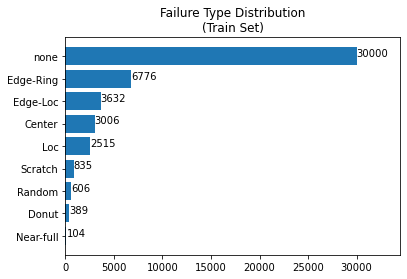

In [8]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

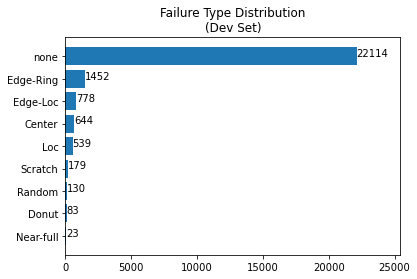

In [9]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

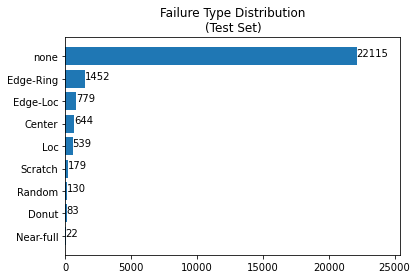

In [10]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [11]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: (#rows, xdim, ydim)
print(x_train.shape)

Wall time: 0.23 seconds
(47863, 60, 60)


In [12]:
# expand tensor and repeat 3 times
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 3])
x_train.shape

Wall time: 0.36 seconds


TensorShape([47863, 60, 60, 1])

In [13]:
# expand tensor and repeat 3 times
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.repeat(x_train, 3, axis=3)
x_val = tf.repeat(x_val, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 3])
x_train.shape

Wall time: 0.75 seconds


TensorShape([47863, 60, 60, 3])

In [14]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = np.asarray(train['classifyLabels']).astype(np.uint8)
y_val = np.asarray(dev['classifyLabels']).astype(np.uint8)
y_test = np.asarray(test['classifyLabels']).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 7
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.00 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


#### Model

In [15]:
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (x, y, 3))
for layer in base_model.layers:
  layer.trainable = False

In [16]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(4096, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001))(x)
x = layers.Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(9, activation='softmax')(x)

In [17]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [18]:
history = head_model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
748/748 [==============================] - 65s 87ms/step - loss: 0.8945 - accuracy: 0.7613 - val_loss: 0.3712 - val_accuracy: 0.9100
Epoch 2/30
748/748 [==============================] - 63s 84ms/step - loss: 0.6305 - accuracy: 0.8167 - val_loss: 0.3773 - val_accuracy: 0.9146
Epoch 3/30
748/748 [==============================] - 63s 84ms/step - loss: 0.5871 - accuracy: 0.8269 - val_loss: 0.3908 - val_accuracy: 0.9063
Epoch 4/30
748/748 [==============================] - 64s 86ms/step - loss: 0.5663 - accuracy: 0.8341 - val_loss: 0.2968 - val_accuracy: 0.9274
Epoch 5/30
748/748 [==============================] - 63s 85ms/step - loss: 0.5492 - accuracy: 0.8377 - val_loss: 0.3201 - val_accuracy: 0.9254
Epoch 6/30
748/748 [==============================] - 61s 82ms/step - loss: 0.5374 - accuracy: 0.8408 - val_loss: 0.4255 - val_accuracy: 0.8940
Epoch 7/30
748/748 [==============================] - 62s 83ms/step - loss: 0.5277 - accuracy: 0.8429 - val_loss: 0.3112 - val_accuracy:

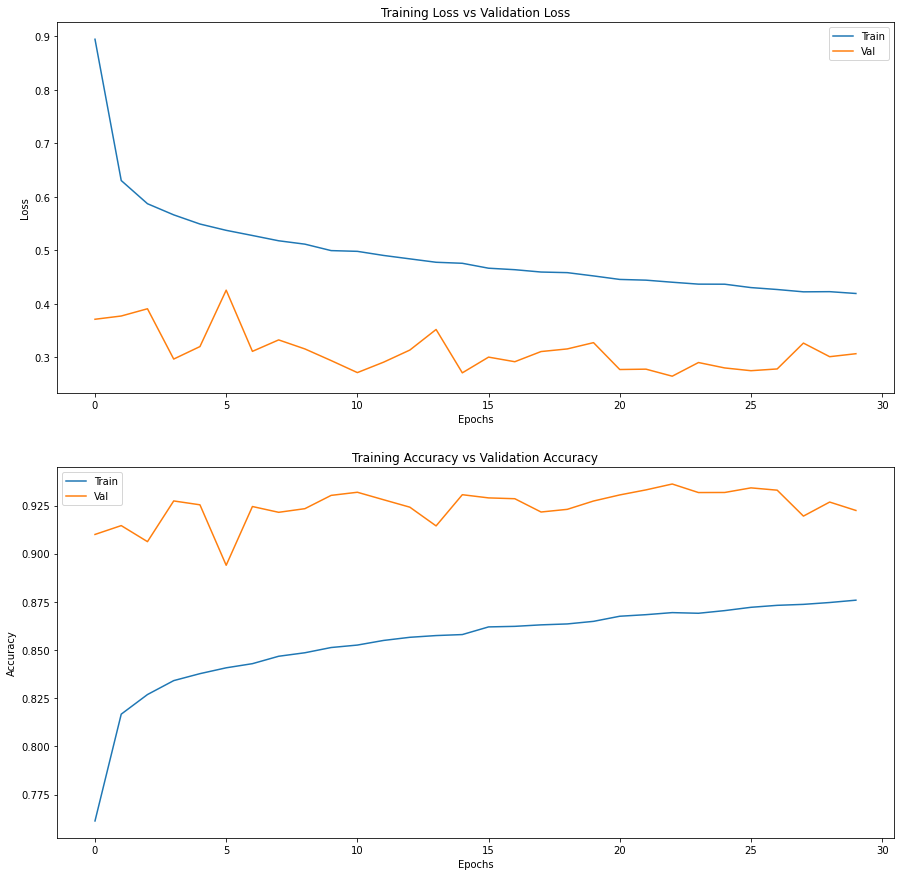

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [20]:
# save model to S3
s3_save_keras_model(head_model, f'{model_id}-{data_id}{note}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpb0v8whm6/resnet-all60/assets


In [21]:
# compute model results on test set
start = time.time()
results = head_model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 27s 33ms/step - loss: 0.3045 - accuracy: 0.9217
Wall time: 27.14 seconds
[0.30453839898109436, 0.9216744303703308]


In [22]:
# generate predictions for model analysis
start = time.time()
y_pred = head_model.predict(x_test)
y_max = np.argmax(y_pred, axis=1)
predictions = [y_max, y_pred]
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 25.799655437469482 seconds


In [23]:
# save predictions
# save to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

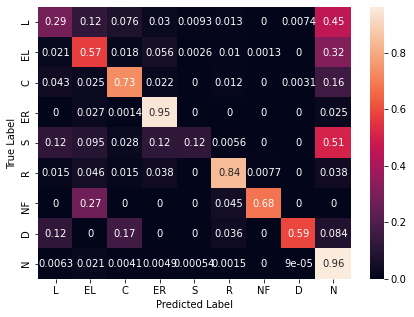

In [25]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=True)

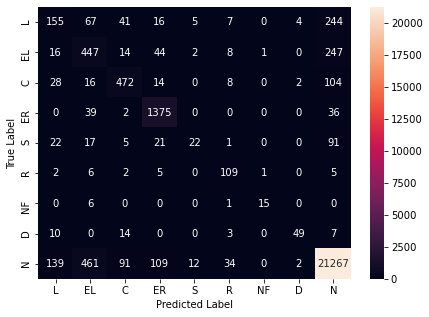

In [26]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=False)